Some errors,
1. Disconnected circuits should be cut during prunning
2. Duplicate circuits should not be gathered
3. Train with updated function
4. Change circuit requirements. Min 2 inputs -> Min 1 input, but now require circuit to have a logic gate.

When testing for different epoch amounts, gather up all these circuits and highlight each better.

Found error:
- Hashing is done before pruning. But some circuits become copies of existing after removing useless wires.

Not error but should change:
- No reason to keep a copy of the probabilties, as they are not cleaned in pruning. Better to just recreate probablities from argmaxed circuits


Problem: 
- Generated circuits often have excess wire. Those excess wires could be found by doing something like shortest path to all connected sockets for each socket in the wireset and then removing the wires that aren't in the fastest path. But that is quite a lot of code for a small change.

Pseudo solution:
- Keep track of the number of wires + components in each circuit, and only use circuits with less or same amount of wires.

In [94]:
import torch
import torch.nn as nn
from CircuitSimulation.CircuitSimulator import *
import numpy as np
from diffusers import UNet2DConditionModel
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import display, clear_output
from matplotlib.colors import ListedColormap
import hashlib
from itertools import combinations
from tqdm import tqdm

In [95]:
# Set dataset

InitialDataset = torch.tensor([
    [
        [1, 1, 1, 1, 1, 2, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ],
    [
        [1, 1, 1, 1, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [1, 1, 0, 1, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [0, 1, 1, 2, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ],
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 3, 1, 1, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ],
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 3, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 1, 1],
    ],
])

""" I'm considering whether the truth table should be changed to always have inputs defined.
Ultimately, i have for now decided against that, for now.
[
    [0, 0, 0, 0, 2, 2, 2, 2],
    [0, 0, 0, 1, 2, 2, 2, 2],
    [0, 0, 1, 0, 2, 2, 2, 2],
    [0, 0, 1, 1, 2, 2, 2, 2],
    [0, 1, 0, 0, 2, 2, 2, 2],
    [0, 1, 0, 1, 2, 2, 2, 2],
    [0, 1, 1, 0, 2, 2, 2, 2],
    [0, 1, 1, 1, 2, 2, 2, 2],
    [1, 0, 0, 0, 2, 2, 2, 2],
    [1, 0, 0, 1, 2, 2, 2, 2],
    [1, 0, 1, 0, 2, 2, 2, 2],
    [1, 0, 1, 1, 2, 2, 2, 2],
    [1, 1, 0, 0, 2, 2, 2, 2],
    [1, 1, 0, 1, 2, 2, 2, 2],
    [1, 1, 1, 0, 2, 2, 2, 2],
    [1, 1, 1, 1, 2, 2, 2, 2],
]
"""
# InitialLabels = torch.tensor([
# 	[
# 		[0, 0, 2, 2, 0, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[0, 1, 2, 2, 0, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[1, 0, 2, 2, 0, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[1, 1, 2, 2, 1, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 	],
# 	[
# 		[0, 0, 2, 2, 0, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[0, 1, 2, 2, 0, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[1, 0, 2, 2, 0, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[1, 1, 2, 2, 1, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 	],
# 	[
# 		[2, 0, 0, 2, 2, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 0, 1, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 1, 0, 2, 2, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 1, 1, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 	],
# ])


InitialLabels = torch.tensor([
    [
        [0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2 ],
    ],
    [
        [0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2 ],
    ],
    [
        [2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2 ],
        [2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2 ],
        [2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2 ],
        [2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2 ],
    ],
    [
        [2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1 ],
        [2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1 ],
        [2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1 ],
        [2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0 ],        
    ],
])

def imageToProbabilities(image, numCategories):
    # The categorical scheduler expects each channel to describe the probability of a pixel being of that class
    # Therefore, a RawCircuit, with one channel, needs to be expanded to have numCategories channels

    bs, h, w = image.shape
    
    imageProbabilites = torch.zeros(bs, numCategories, h, w)
    for b in range(bs):
        for i in range(h):
            for j in range(w):
                pixelClass = image[b, i, j]
                imageProbabilites[b, pixelClass, i, j] = 1.0

    return imageProbabilites



argmaxedDataset = InitialDataset # Keep a reduced version of the data for hashing
# Add channel dimension: [2, 10, 10] → [2, 4, 10, 10]
InitialDataset = imageToProbabilities(InitialDataset, 4)

N = 4 # Duplicate dataset N times, to better make use of batching
InitialDataset = InitialDataset.repeat((N, 1, 1, 1))  
InitialLabels = InitialLabels.repeat((N, 1, 1))       

# Wrap in a TensorDataset
dataset = TensorDataset(InitialDataset, InitialLabels)

# Create DataLoader
loader = DataLoader(dataset, batch_size=64, shuffle=True)

print("dataset generated as 'loader")

dataset generated as 'loader


In [96]:
def countWires(circuit):
    sum = 0
    for i in range(circuit.shape[0]):
        for j in range(circuit.shape[1]):
            if circuit[i][j] >= 1:
                sum += 1
    return sum

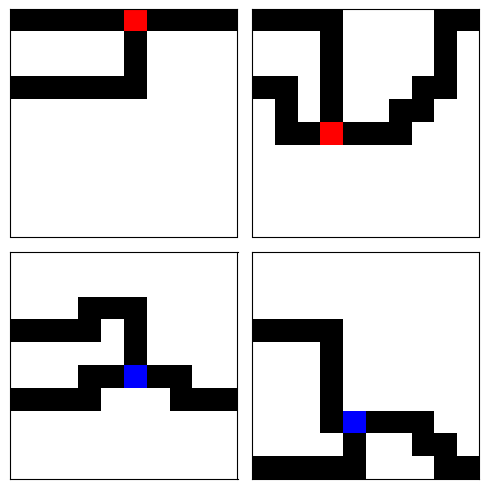

In [97]:
# Show dataset circuits

cmap = ListedColormap(['white', 'black', 'red', 'blue'])
fig, axes = plt.subplots(2, 2, figsize=(5, 5))
for idx, ax in enumerate(axes.flat):
    ax.imshow(argmaxedDataset[idx], cmap=cmap, interpolation='nearest', vmin=0, vmax=3)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [98]:
# Set truthtable embedder

class RowEmbedder(nn.Module):
    def __init__(self, num_categories, vector_length, embedding_dim):
        super().__init__()
        self.shared_embed = nn.Embedding(num_categories, embedding_dim)
        self.position_weights = nn.Parameter(torch.ones(vector_length, embedding_dim))
        self.position_bias = nn.Parameter(torch.zeros(vector_length, embedding_dim))
        
    def forward(self, x):
        # x shape: [batch_size, vector_length]
        shared = self.shared_embed(x)  # [batch_size, vector_length, emb_dim]
        # Apply position-specific scaling and shifting
        return shared * self.position_weights + self.position_bias
    

class TabularTransformer(nn.Module):
    def __init__(self, num_categories, num_features, d_model):
        super().__init__()
        self.d_model = d_model

        self.row_embedding = RowEmbedder(num_categories, num_features, d_model) #num_categories, vector_length, embedding_dim

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model * num_features,
            nhead=8,
            dim_feedforward=2*d_model * num_features,
            batch_first=True,
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=6,
        )
    
    def forward(self, x):
        #batch_size, num_rows, num_cols = x.shape

        rows = self.row_embedding(x) #bs, rows, columns, embedding
        #rows = rows.mean(dim=2)
        rows = rows.flatten(start_dim=2) 
        
    
        transformed = self.transformer(rows)

        return transformed

transformer = TabularTransformer(3, 12, 16)

print("embedder created as transformer")
print(f"Embedded shape: {transformer(InitialLabels)[0].shape}")

embedder created as transformer
Embedded shape: torch.Size([4, 192])


In [99]:
# Set up scheduler

class CategoricalScheduler:
    def __init__(self, TrainSteps = 200, numCategories = 4, betaStart = 0.0001, betaEnd = 0.02):
        self.TrainSteps = TrainSteps
        self.noiseDevice = 'cpu'
        self.numCategories = numCategories

        self.betas = torch.linspace(betaStart, betaEnd, TrainSteps, device=self.noiseDevice)
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)

    def addNoise(self, imageBatch, time):
        bs, ch, w, h = imageBatch.shape

        with torch.no_grad():
            alpha_t = self.alpha_cumprod[time].view(-1, 1, 1, 1) # Translates shape (1,) -> (1, 1, 1, 1)

            # the per pixel probability distribution of the categories
            currentProbabilities = imageBatch

            # The chance of each state per pixel when noised            
            updatedProbabilities = currentProbabilities * alpha_t + (1 - alpha_t) / self.numCategories 
            updatedProbabilities = updatedProbabilities.permute(0, 2, 3, 1) # reshape such that it is flattened correctly below
            updatedProbabilities = updatedProbabilities.reshape(bs*w*h, self.numCategories)  
            

            # 1 Sample per value
            categoricalNoise = torch.multinomial(updatedProbabilities, 1, replacement=True)
            categoricalNoise = categoricalNoise.view(bs, w, h) # Shape: [bs, w, h]

            noisedImages = F.one_hot(categoricalNoise, num_classes=self.numCategories)
            noisedImages = noisedImages.permute(0, 3, 1, 2) # [bs, num_classes, w, h]

            return noisedImages

scheduler = CategoricalScheduler()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [100]:
# Create Diffuser

class CategoricalDiffusionModel(nn.Module):
    def __init__(self, imageSize, numCategories, embeddingSize, attentionHeads=8, guidanceProb=0.1):
        super().__init__()
        self.guidance_prob=guidanceProb
        self.model = UNet2DConditionModel(
            sample_size=imageSize, 
            in_channels=numCategories,  # Image channels
            out_channels=numCategories,
            cross_attention_dim=embeddingSize,  # Matches mbedding's token dim 
            attention_head_dim=attentionHeads,     # Smaller head dim for efficiency
            layers_per_block=2,       # how many ResNet layers to use per UNet block
            block_out_channels=(128, 128, 128), 
            down_block_types=(
                "CrossAttnDownBlock2D",  
                "CrossAttnDownBlock2D",
                "DownBlock2D",
            ),
            up_block_types=(
                "UpBlock2D",
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
            ),
        )
        
    def forward(self, x, t, embedding):
        bs, ch, w, h = x.shape

        #Use guidance probability, to help the model learn that 'circuit behvaior' 
        # is a general feature and not specific to a particular embedding.
        if self.training:
            mask = torch.rand_like(embedding, device=x.device) < self.guidance_prob
            embedding[mask] = 0

        return self.model(x, t, encoder_hidden_states=embedding).sample

loss = []
model = CategoricalDiffusionModel(10, 4, 192).to(device)

^Doubled channel size in unet

In [101]:
# Training Function

def trainCatModel(catModel, dataloader, epochs, embeddingModel, losses, PLOTUPDATES = True):
    catModel.train()
    updateRate = 10 # For plotting purposes

    loss_fn = nn.CrossEntropyLoss() #nn.MSELoss(reduction='sum')

    if PLOTUPDATES:
        fig, ax = plt.subplots(figsize=(8, 5))
    
    opt = torch.optim.Adam(model.parameters(), lr=1e-4) 

    for epoch in range(epochs):
        
        for batch, labels in dataloader:

            timesteps = torch.randint(0, scheduler.TrainSteps - 1, (batch.shape[0],), device='cpu').long()

            noisyImgs = scheduler.addNoise(batch, timesteps)

            embeddings = embeddingModel(labels)

            pred = model(noisyImgs.to(device).float(), timesteps.to(device), embeddings.to(device))

            loss = loss_fn(pred, batch.to(device).argmax(axis=1)) 

            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.item())

        if PLOTUPDATES:
            if epoch % updateRate == 0:
                clear_output(wait=True)  
                ax.clear()
                plt.plot(losses)
                plt.xlabel('Batch')
                display(fig)
    
    if PLOTUPDATES:
        clear_output(wait=True)  
        ax.clear()
    plt.plot(losses)
    plt.xlabel('Batch')
    if PLOTUPDATES:
        display(fig)

    return catModel, losses

In [102]:
# Create hashes of data to compare synthetic data with real data

# Function to get the hash of a tensor
def get_tensor_hash(tensor):
    # Flatten the tensor and convert to tuple (hashable)
    tensor_tuple = tuple(tensor.flatten().tolist())
    
    # Compute the hash using hashlib (SHA-256)
    hash_object = hashlib.sha256(str(tensor_tuple).encode())
    return hash_object.hexdigest()

dataset_hashes = {get_tensor_hash(tensor) for tensor in argmaxedDataset}
labels_hashes = {get_tensor_hash(tensor) for tensor in InitialLabels}

# This would be more efficient sorted

# print("Dataset Hashes:", dataset_hashes)
# print("Labels Hashes:", labels_hashes)
print("Dataset hash amount:", len(dataset_hashes))

Dataset hash amount: 4


In [103]:
# Sockets used for testing

inpSockets = [
    (Socket("inp0", True), (-1, 0)), 
    (Socket("inp1", True), (-1, 3)), 
    (Socket("inp2", True), (-1, 6)), 
    (Socket("inp3", True), (-1, 9)), 
]

outSockets = [  
    (Socket("out0", False), (10, 0)), 
    (Socket("out1", False), (10, 3)), 
    (Socket("out2", False), (10, 6)), 
    (Socket("out3", False), (10, 9)),
]

In [104]:
# Why pre and after pruning?
# Pruning unconnected wires won't make simulation faster, as they aren't even used in the connection or socket maps.
# So the idea was to only prune these things before adding them to the dataset.
# However, when checking if the generated circuit already exists, it helps also removing those wires
# So both pre and after pruning are used before simulating, yet the functions are kept separate, as is.


# Prunes inputs, outputs and wireSets that have only have components recieving or emitting signals.
# Wiresets with no components connected are never added to the connectionMap, so they are not pruned here, -
# These wiresets have no influence on the circuit's behavior (or simulation speed), -
# so pruning them can wait till after the circuit has been confirmed to be useful
def prePruning(connectionMap, socketMap):
    prunedConnections = []
    for connection in connectionMap:
        relevantConnection = any(
            component.isSource for component in connectionMap[connection]
        ) and any(
            not component.isSource for component in connectionMap[connection]
        )
        
        if not relevantConnection:
            prunedConnections.append(connection)

    for connection in prunedConnections:
        del connectionMap[connection]  

    connectedInputs = []
    connectedOutputs = []
    for socket, connections in socketMap.items():
        for connection in list(connections):
            if connection in prunedConnections:
                socketMap[socket].remove(connection)
                
        prefix, compid, comptype = socket.name
        
        if prefix == "inp" and bool(socketMap[socket]):
            connectedInputs.append(int(compid))
        elif prefix == "out" and bool(socketMap[socket]):
            connectedOutputs.append(int(compid))
    
    return connectedInputs, connectedOutputs


# Of the connected inputs, get combinations for a truthtable. for example socket [[], [0], [1], [0,1]]
def generateSocketCombinations(inputSockets, relevantIndexes):
    #inputSockets = All available input sockets
    #relevantIndexes = the indexes of sockets that are connected to components
    
    usedSockets = [inputSockets[i][0] for i in relevantIndexes]
    
    # Generate all combinations (power set)
    orderList = []
    for r in range(len(usedSockets) + 1):
        for combo in combinations(usedSockets, r):
            orderList.append(list(combo))
    
    return orderList

In [105]:
# After pruning

# Things to prune:
# Unconncted wires
# wires from prepruning

def afterPruning(circuit, wiresets, connectionMap):
    # Prunes circuits, from pruned connections
    # And replaces gates that aren't connected on their emitter with wires.
    circuitWasUpdated = False

    for i in range(circuit.shape[0]):
        for j in range(circuit.shape[1]):
            if wiresets[i][j] not in connectionMap and circuit[i][j] == 1:
                circuit[i][j] = 0
                circuitWasUpdated = True
            elif circuit[i][j] > 1 and j < circuit.shape[1] - 1 and circuit[i][j + 1] == 0:
                circuit[i][j] = 1
                circuitWasUpdated = True

    #Because there gate positions aren't stored, socket map will have to be recreated, but then connetionmap will also need to be updated.
    return circuit, connectionMap, circuitWasUpdated

In [106]:
def GetTruthTable(inputIndexes, outputIndexes, socketMap, connectionMap, orders):
    # Orders is a list of the order in which input sockets are activated.
    # # Truthtables usually do not make use of activation order, but the simulation needs it.

    truthTable = torch.ones(size=(2**len(inputIndexes), 8)) * 2

    row = 0
    #try
    for order in orders:
        for socket in socketMap.keys():
            socket.state = False
        
        # Gives the state of sockets at the end. But only output sockets are relevant, 
        # and those are available through outSockets[i][0]
        _ = Simulate(connectionMap, socketMap, order) 

        for index in inputIndexes:
            truthTable[row][index] = 0

        for socket in order:
            prefix, idnum, comptype = socket.name
            truthTable[row][int(idnum)] = 1

        for i in outputIndexes:
            truthTable[row][i + 4] = outSockets[i][0].state

        row += 1

    return truthTable

In [107]:
# Generate N Circuits
def GenerateN(model, amount = 100):
    model.eval()
    
    ## GENERATE CIRCUITS
    with torch.no_grad():
        batchX = torch.randint(size=(amount, 4, 10, 10), high = 1, low = 0, device=device )
        batchY = torch.randint(size=(amount, 4, 12), high = 2, low = 0, device='cpu' ) # WARNING! This is currently forced to shape (4, 12)
        batchY = transformer(batchY).to(device)
        
        # Inference with trainingsteps // 64 + 1, for faster generations. Even with this few steps, generations become perfect after training, due to small dataset.
        stepDivisor = 64
        inferenceSteps = torch.linspace(scheduler.TrainSteps-1, 1, scheduler.TrainSteps // stepDivisor, device='cpu').long()

        for t in tqdm(inferenceSteps):
            residual_cond = model(batchX.to(device).float(), t, batchY.float()) 
            residual = F.softmax(residual_cond, dim=1)
            batchX = scheduler.addNoise(residual.to('cpu'), t - 1).float()
        batchX = F.softmax(model(batchX.to(device), 0, batchY), dim=1)

        # Get circuit values
        argmaxedBatch = torch.argmax(batchX, dim=1, keepdim=True).cpu().numpy().squeeze()

        return argmaxedBatch

def getTables(circuits):
    #Prunes
    #Checks hashes
    #Simulates
    #Then, generates tables
    with torch.no_grad():
        tables = []
        simulatedCircuits = []

        unique_hashes = {}
        for i in tqdm(range((circuits.shape[0]))):
            circuitDirty = True # Pruning flag

            while circuitDirty:
                socketMap, wireSets = GetSocketMap(circuits[i], inpSockets + outSockets)
                connectionMap = GetConnectionMap(socketMap)


                inps, outs = prePruning(connectionMap, socketMap)
                circuit, connectionMap, circuitDirty = afterPruning(circuits[i], wireSets, connectionMap)

            hash = get_tensor_hash(circuit)
            if hash not in unique_hashes and hash not in dataset_hashes:
                unique_hashes[hash] = i

                #Get orderlist
                if len(inps) > 1 and len(outs) > 0: # Bias to have only circuits with at least 2 inputs
                    orderlist = generateSocketCombinations(inpSockets, inps)

                    try:    
                        truthTable = GetTruthTable(inps, outs, socketMap, connectionMap, orderlist)
                        tables.append(truthTable)
                        simulatedCircuits.append(circuit)

                    except Exception as e:
                        print(f"Error in circuit {i}: {e}")
                
        return tables, simulatedCircuits

In [108]:
# The 3 above functions concattenated 

def GenerateAndSimulate(model, lossList, amount = 100, plotResults = True):
    argmaxCircuits = GenerateN(model, amount)

    tables, simulatedCircuits = getTables(argmaxCircuits)
    print(f"Generated {len(tables)} truth tables. {len(argmaxCircuits) - len(tables)} circuits weren't used")

    if plotResults:
        # plot the top 25 circuits.
        cmap = ListedColormap(['white', 'black', 'red', 'blue'])
        cols = 5
        rows = min(len(simulatedCircuits) + 4, 25) // cols
        if rows == 0:
            return tables, simulatedCircuits

        fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))

        for idx, ax in enumerate(axes.flat):
            ax.set_xticks([])
            ax.set_yticks([])
            if idx >= len(simulatedCircuits):
                continue
            ax.imshow(simulatedCircuits[idx], cmap=cmap, interpolation='nearest', vmin=0, vmax=3)

        fig.suptitle(f"Epoch {len(lossList)}")
        plt.tight_layout()
        plt.show()

    return tables, simulatedCircuits

____________________
When running after pruning on a single example, it works, but when runing within getTables function, it just doesn't do anything. 

Therefore:
- Try to run each piece of GenerateAndSimulate individually, and find out how to minimally recreate the error.

100%|██████████| 3/3 [00:00<00:00, 10.09it/s]


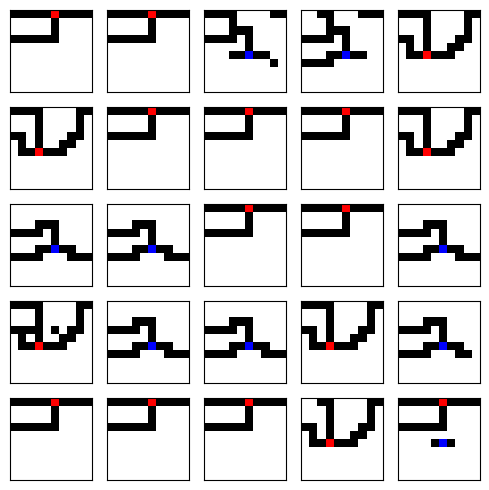

In [87]:
argmaxCircuits = GenerateN(model, 25)

cmap = ListedColormap(['white', 'black', 'red', 'blue'])
cols = 5
rows = 5
fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))

for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(argmaxCircuits[idx], cmap=cmap, interpolation='nearest', vmin=0, vmax=3)

plt.tight_layout()
plt.show()


100%|██████████| 25/25 [00:00<00:00, 3237.74it/s]


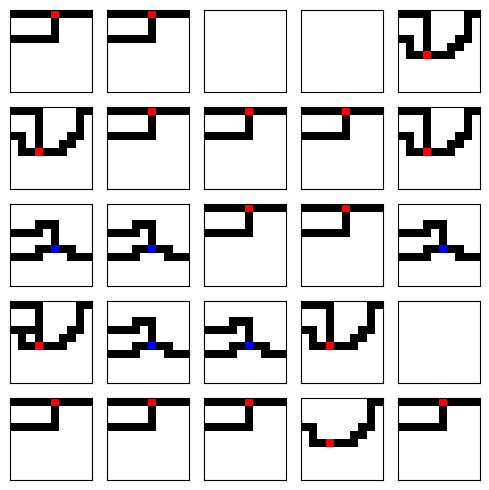

In [88]:
tables, simulatedCircuits = getTables(argmaxCircuits)

cmap = ListedColormap(['white', 'black', 'red', 'blue'])
cols = 5
rows = 5
fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))

for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(argmaxCircuits[idx], cmap=cmap, interpolation='nearest', vmin=0, vmax=3)

plt.tight_layout()
plt.show()

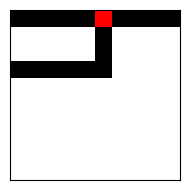

In [109]:
# function to print a single circuit

def printCircuit(circuit):
    cmap = ListedColormap(['white', 'black', 'red', 'blue'])
    fig, ax = plt.subplots(figsize=(2, 2))

    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(circuit, cmap=cmap, interpolation='nearest', vmin=0, vmax=3)
    plt.tight_layout()
    plt.show()

printCircuit(argmaxCircuits[6])

Alot of these are getting removed from generate and simulate.

______________

In [110]:
model = CategoricalDiffusionModel(10, 4, 192).to(device)
loss = []
SyntheticCircuits = {}

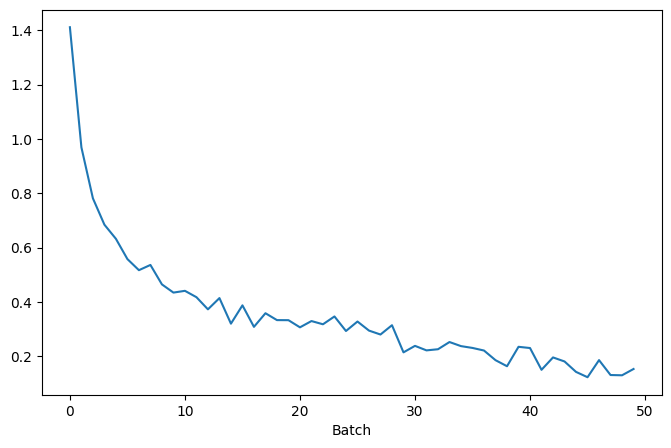

100%|██████████| 500/500 [00:00<00:00, 4011.23it/s]


Generated 19 truth tables. 481 circuits weren't used


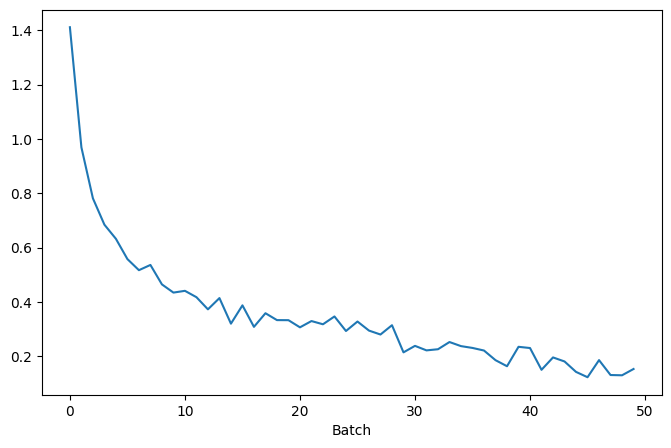

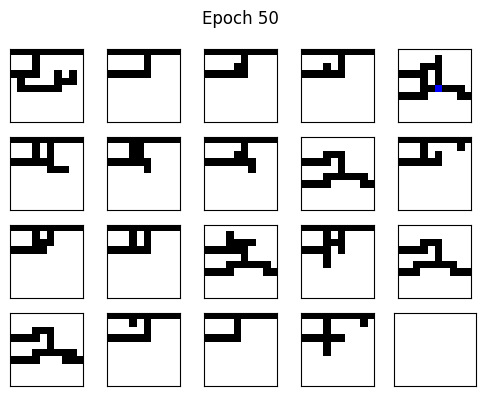

In [111]:
model, loss = trainCatModel(model, loader, 50, transformer, loss)
t, a = GenerateAndSimulate(model, loss, amount=500)
SyntheticCircuits[len(loss)] = a

In [112]:

testCircuit = a[8]
print(testCircuit)

socketMap, wireSets = GetSocketMap(testCircuit, inpSockets + outSockets)
print(socketMap)
print(wireSets)

connectionMap = GetConnectionMap(socketMap)
print(connectionMap)


inps, outs = prePruning(connectionMap, socketMap)
print(inps)
print(outs)
circuit, connectionMap = afterPruning(testCircuit, wireSets, connectionMap)
print(circuit)

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 0 0 0 0]
 [1 1 1 1 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 0]
 [1 1 1 1 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
{inp0: set(), inp1: {1}, inp2: {1}, inp3: set(), out0: set(), out1: set(), out2: {1}, out3: set()}
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 0 0 0 0]
 [1 1 1 1 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 0]
 [1 1 1 1 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
{1: [inp1, inp2, out2]}
[1, 2]
[2]


ValueError: too many values to unpack (expected 2)

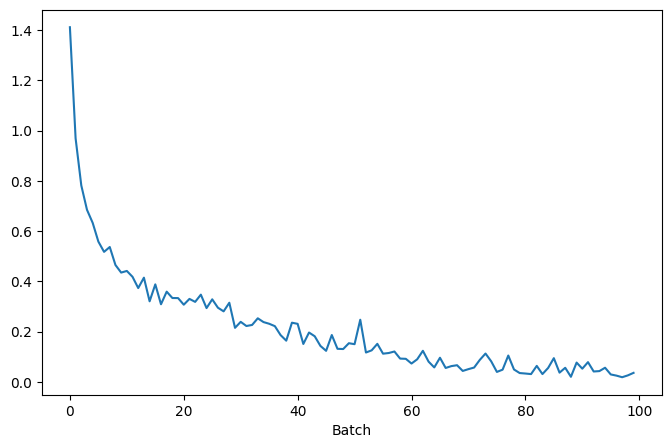

100%|██████████| 500/500 [00:00<00:00, 4840.34it/s]


Generated 25 truth tables. 475 circuits weren't used


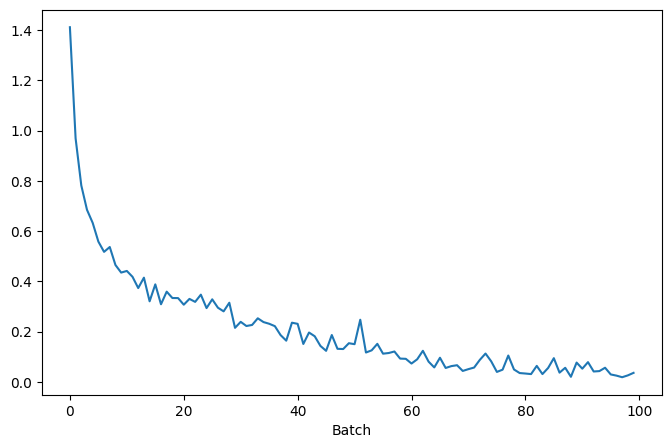

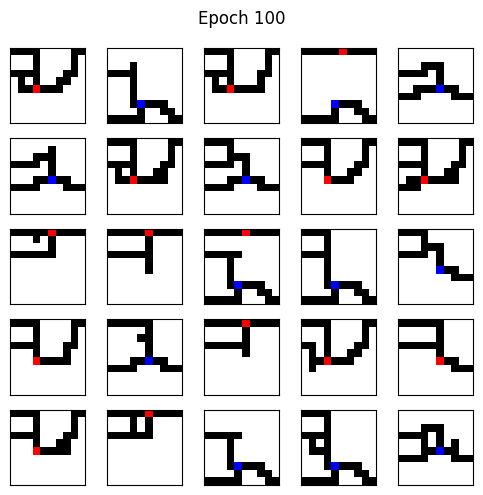

In [113]:
model, loss = trainCatModel(model, loader, 50, transformer, loss)
t, a = GenerateAndSimulate(model, loss, amount=500)
SyntheticCircuits[len(loss)] = a

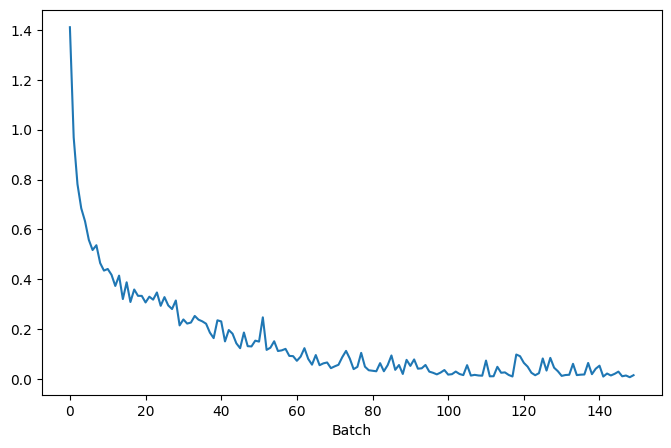

100%|██████████| 500/500 [00:00<00:00, 6322.05it/s]

Generated 7 truth tables. 493 circuits weren't used


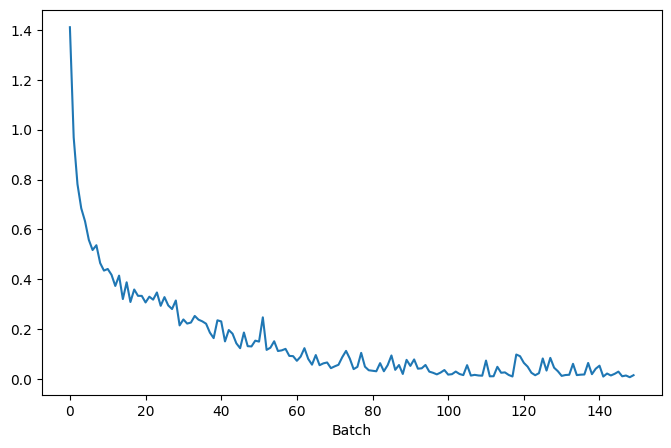

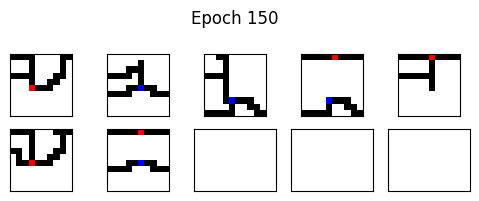

In [114]:
model, loss = trainCatModel(model, loader, 50, transformer, loss)
t, a = GenerateAndSimulate(model, loss, amount=500)
SyntheticCircuits[len(loss)] = a

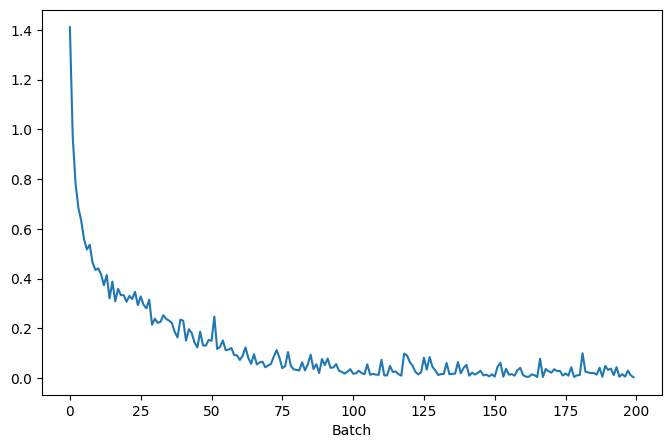

100%|██████████| 500/500 [00:00<00:00, 5551.56it/s]


Generated 19 truth tables. 481 circuits weren't used


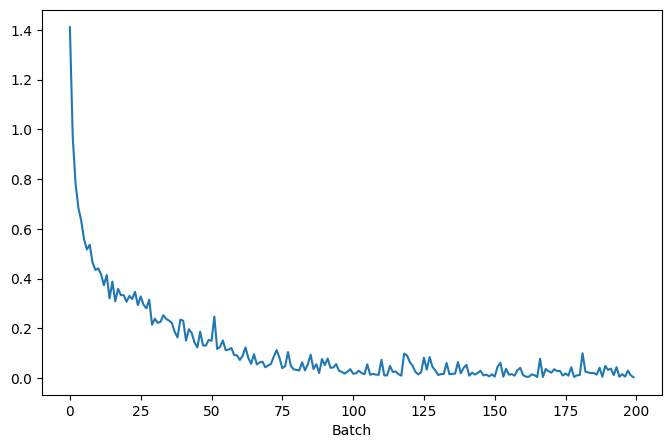

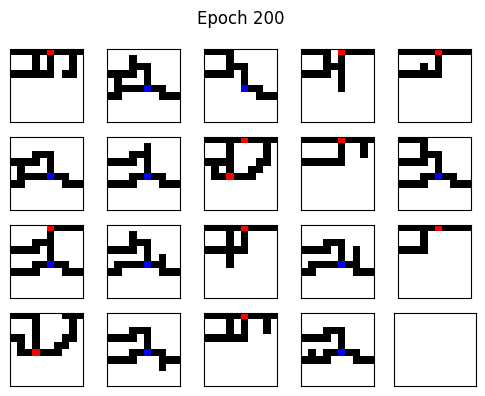

In [115]:
model, loss = trainCatModel(model, loader, 50, transformer, loss)
t, a = GenerateAndSimulate(model, loss, amount=500)
SyntheticCircuits[len(loss)] = a

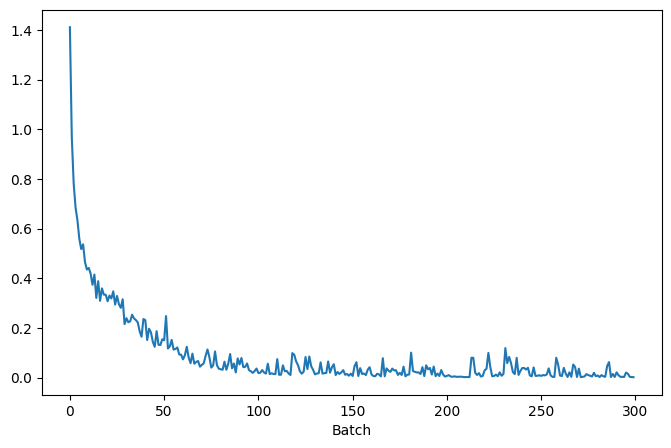

100%|██████████| 500/500 [00:00<00:00, 6484.56it/s]

Generated 4 truth tables. 496 circuits weren't used


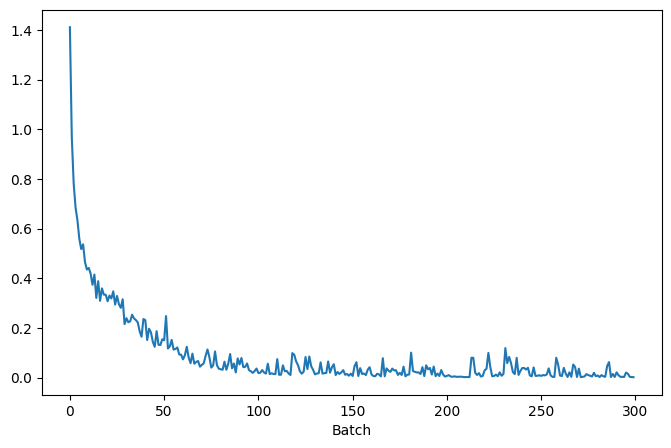

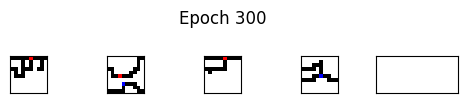

In [116]:
model, loss = trainCatModel(model, loader, 100, transformer, loss)
t, a = GenerateAndSimulate(model, loss, amount=500)
SyntheticCircuits[len(loss)] = a

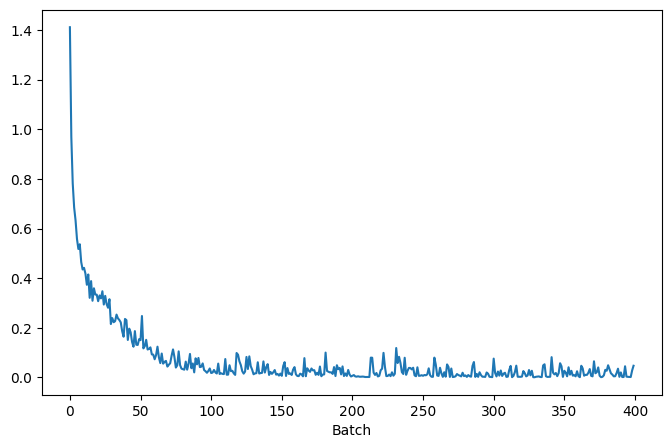

100%|██████████| 500/500 [00:00<00:00, 6521.42it/s]

Generated 9 truth tables. 491 circuits weren't used


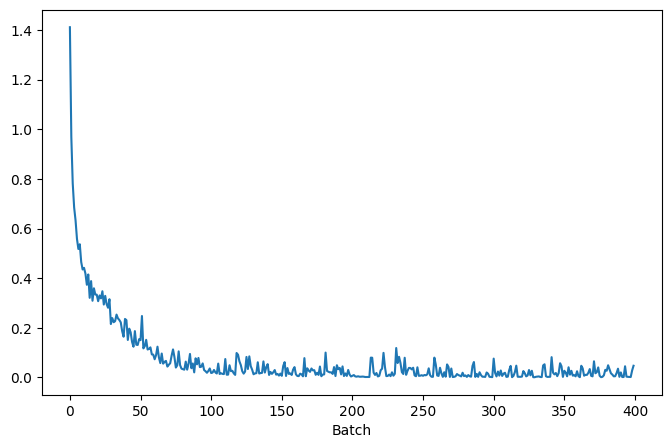

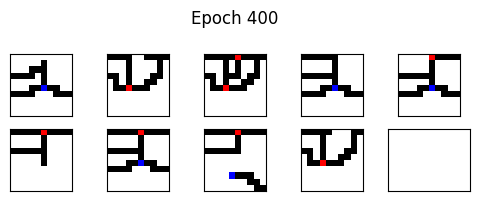

In [117]:
model, loss = trainCatModel(model, loader, 100, transformer, loss)
t, a = GenerateAndSimulate(model, loss, amount=500)
SyntheticCircuits[len(loss)] = a

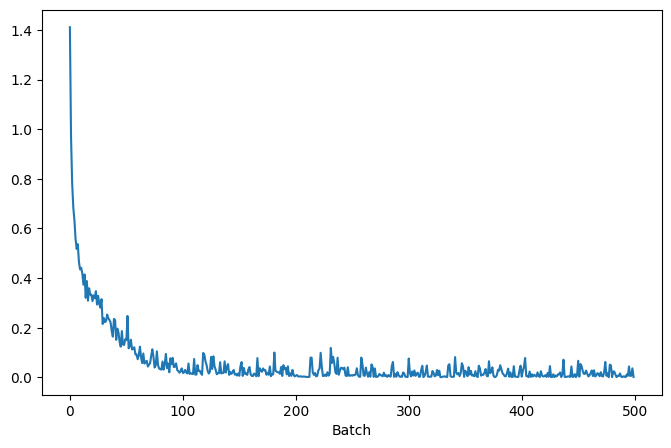

100%|██████████| 500/500 [00:00<00:00, 6714.86it/s]

Generated 10 truth tables. 490 circuits weren't used


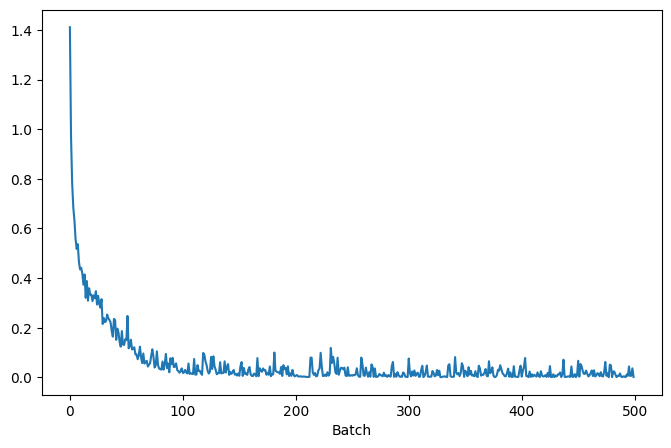

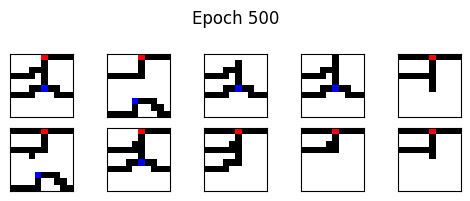

In [118]:
model, loss = trainCatModel(model, loader, 100, transformer, loss)
t, a = GenerateAndSimulate(model, loss, amount=500)
SyntheticCircuits[len(loss)] = a

In [119]:
for key in SyntheticCircuits.keys():
    print(f"For epoch {key}, {len(SyntheticCircuits[key])} new circuits were generated.")

For epoch 50, 19 new circuits were generated.
For epoch 100, 25 new circuits were generated.
For epoch 150, 7 new circuits were generated.
For epoch 200, 19 new circuits were generated.
For epoch 300, 4 new circuits were generated.
For epoch 400, 9 new circuits were generated.
For epoch 500, 10 new circuits were generated.


It is a rough estimation, but for now, lets use 200 epochs as the point for gnerating new circuits.